# 2. EDA and Generation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
processed_path = "../../Datasets/Beijing_House_Price_Dataset/processed_beijing.csv"
df = pd.read_csv(processed_path, encoding="UTF-8", low_memory=False)

In [3]:
lat = df["Lat"]
lng = df["Lng"]

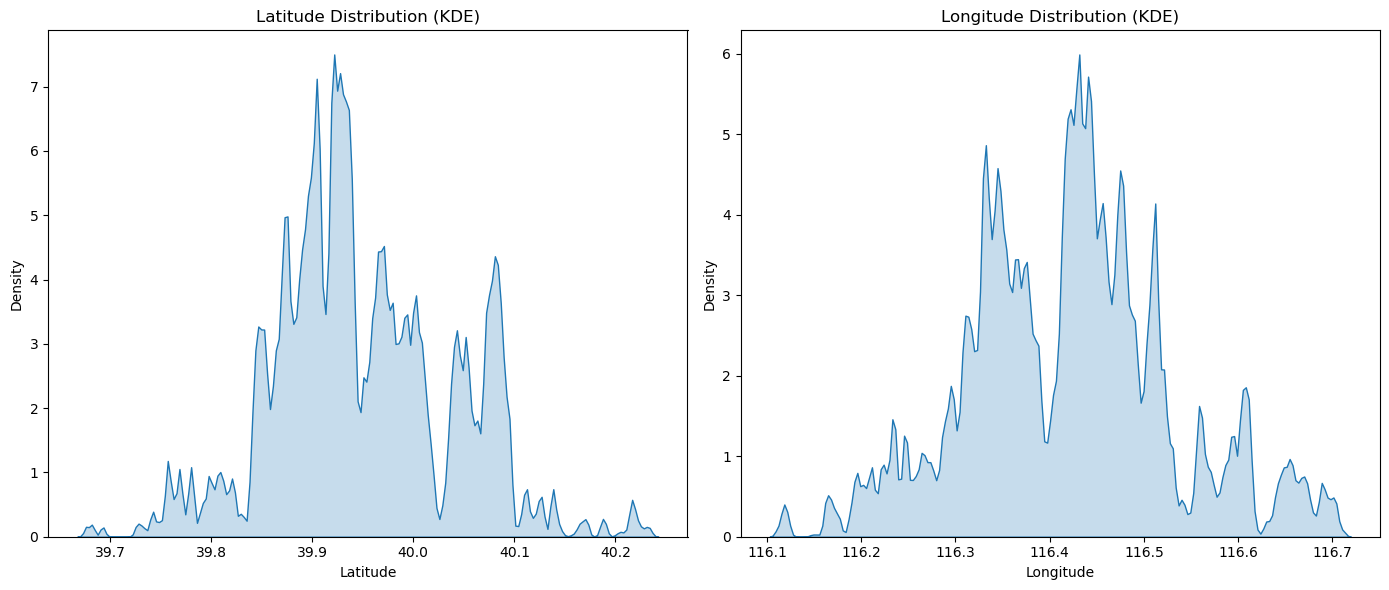

In [4]:
plt.figure(figsize=(14, 6))

# Latitude distribution
plt.subplot(1, 2, 1)
sns.kdeplot(data=df, x='Lat', bw_adjust=0.3, fill=True)
plt.title('Latitude Distribution (KDE)')
plt.xlabel('Latitude')

# Longitude distribution
plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x='Lng', bw_adjust=0.3, fill=True)
plt.title('Longitude Distribution (KDE)')
plt.xlabel('Longitude')

plt.tight_layout()
plt.show()

In [5]:
lat_min, lat_max = lat.min(), lat.max()
lng_min, lng_max = lng.min(), lng.max()

# calculate the center coordinate
center_lat = (lat_min + lat_max) / 2
center_lng = (lng_min + lng_max) / 2
print(lat_min, lat_max)
print(lng_min, lng_max)
print(center_lat, center_lng)

39.674171 40.235853
116.111318 116.711337
39.955011999999996 116.4113275


In [6]:
from math import cos, radians

EARTH_RADIUS = 6371
lat_degree_per_km = 1 / 111
lng_degree_per_km = 1 / (EARTH_RADIUS * cos(radians(center_lat)) * np.pi / 180)
print(lat_degree_per_km, lng_degree_per_km)

0.009009009009009009 0.01173208371377924


In [7]:
grid_length_lat = 2
grid_length_lng = 2
grid_num = 12
total_lat = grid_length_lat * grid_num
total_lng = grid_length_lng * grid_num
lat_span = total_lat * lat_degree_per_km
lng_span = total_lng * lng_degree_per_km
print(lng_span, lat_span)

0.28157000913070174 0.21621621621621623


In [8]:
# coordinates of four corners
north = center_lat + lat_span/2
south = center_lat - lat_span/2
east = center_lng + lng_span/2
west = center_lng - lng_span/2

corners = {
    "northwest": (north, west),
    "northeast": (north, east),
    "southwest": (south, west),
    "southeast": (south, east)
}
print(corners)

{'northwest': (40.0631201081081, 116.27054249543465), 'northeast': (40.0631201081081, 116.55211250456534), 'southwest': (39.84690389189189, 116.27054249543465), 'southeast': (39.84690389189189, 116.55211250456534)}


In [9]:
# from math import log2


# def calculate_entropy(y):
#     value_counts = y.value_counts()
#     entropy = 0
#     for count in value_counts:
#         prob = count / len(y)
#         entropy -= prob * log2(prob)
#     return entropy

# def calculate_information_gain(df, feature, target):
#     total_entropy = calculate_entropy(df[target])
    
#     feature_values = df[feature].unique()
#     weighted_entropy_sum = 0
    
#     for value in feature_values:
#         subset = df[df[feature] == value]
#         weighted_entropy_sum += (len(subset) / len(df)) * calculate_entropy(subset[target])
    
#     info_gain = total_entropy - weighted_entropy_sum
#     return info_gain


# target_column = 'totalPrice'
# exclude_columns = ['totalPrice', 'Lat', 'Lng', 'tradeTime', 'month']
# features = df.columns[~df.columns.isin(exclude_columns)]

# info_gains = {feature: calculate_information_gain(df, feature, target_column) for feature in features}

# info_gain_df = pd.DataFrame(list(info_gains.items()), columns=['Feature', 'Information Gain'])
# info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)
# print(info_gain_df)

#### we can find out that "price", "square", "communityAverage", "distance" has sinificant impacts on the "totalPrice"

In [10]:
# def plot_monthly_transactions():
#     # Create lists to store data
#     months = []
#     transaction_counts = []
    
#     # Collect data for each month
#     for i in range(1, 49):
#         m = 2014 * 12 + i
#         year = m // 12
#         month = m % 12
#         if month == 0:
#             month = 12
#             year -= 1
            
#         transaction_count = len(df[df['month'] == m])
        
#         months.append(f"{year}-{month:02d}")
#         transaction_counts.append(transaction_count)
    
#     # Create the plot
#     plt.figure(figsize=(15, 6))
#     sns.set_style("whitegrid")
    
#     # Plot line chart
#     plt.plot(months, transaction_counts, marker='o')
    
#     # Customize the plot
#     plt.title('Monthly Transaction Count (2014-2017)', fontsize=14)
#     plt.xlabel('Month', fontsize=12)
#     plt.ylabel('Number of Transactions', fontsize=12)
#     plt.xticks(rotation=45)
    
#     # Add grid
#     plt.grid(True, linestyle='--', alpha=0.7)
    
#     # Adjust layout to prevent label cutoff
#     plt.tight_layout()
    
#     return plt.gcf()

# # Generate and display the plot
# fig = plot_monthly_transactions()
# plt.show()

In [11]:
def cal_house_price_mat(start: str, end: str):
    total_price = np.zeros((grid_num, grid_num), dtype=float)
    cnt = np.zeros((grid_num, grid_num), dtype=float)
    count = 0
    valid = 0
    # Find the first row with the start month
    start_idx = df[df["month"] >= start].index[0]

    for _, row in df.iloc[start_idx:].iterrows():
        cur_lat = row["Lat"]
        cur_lng = row["Lng"]
        month = row["month"]
        if month > end:
            break
        if start <= month <= end and south <= cur_lat <= north and west <= cur_lng <= east:
            ri = int(abs(cur_lat - north) // (lat_degree_per_km * grid_length_lat))
            ci = int((cur_lng - west) // (lng_degree_per_km * grid_length_lng))
            count += 1
            if 0 <= ri <= grid_num - 1 and 0 <= ci <= grid_num - 1:
                total_price[ri][ci] += row["totalPrice"]
                cnt[ri][ci] += 1
                valid += 1
    # print("house_price total:", count, "valid: ", valid)
    devider = cnt.copy()
    devider = np.where(devider == 0, 1e-6, cnt)
    return total_price / devider, cnt

In [12]:
# 2012, 2013, 2014, 2015, 2016, 2017
gdp_growth = [7.7, 7.7, 7.3, 6.9, 6.7, 6.7]
mortagage_rates_1_5 = [4.1, 4.1, 3.75, 3.125, 3.125, 3.125]
mortagage_rates_5 = [4.6, 4.6, 4.25, 3.625, 3.625, 3.625]
avg_incoming = [62677, 69521, 77560, 85038, 92477, 101599]
unemployment_rate = [1.27, 1.21, 1.31, 1.39, 1.41, 1.43]
permanent_residents = [2069.3, 2114.8, 2151.6, 2170.5, 2172.9, 2170.7]
economics = [gdp_growth, mortagage_rates_1_5, mortagage_rates_5, avg_incoming, unemployment_rate, permanent_residents]


def cal_ingredients_mat(start: str, end: str):
    price = np.zeros((grid_num, grid_num), dtype=float)
    square = np.zeros((grid_num, grid_num), dtype=float)
    community = np.zeros((grid_num, grid_num), dtype=float)
    distance = np.zeros((grid_num, grid_num), dtype=float)
    cnt = np.zeros((grid_num, grid_num), dtype=float)
    count = 0
    valid = 0
    # Find the first row with the start month
    start_idx = df[df["month"] >= start].index[0]

    for _, row in df.iloc[start_idx:].iterrows():
        cur_lat = row["Lat"]
        cur_lng = row["Lng"]
        month = row["month"]
        if month > end:
            break
        if start <= month <= end and south <= cur_lat <= north and west <= cur_lng <= east:
            ri = int(abs(cur_lat - north) // (lat_degree_per_km * grid_length_lat))
            ci = int((cur_lng - west) // (lng_degree_per_km * grid_length_lng))
            count += 1
            if 0 <= ri <= grid_num - 1 and 0 <= ci <= grid_num - 1:
                price[ri][ci] += row["price"]
                square[ri][ci] += row["square"]
                community[ri][ci] += row["communityAverage"]
                distance[ri][ci] += row["distance"]
                cnt[ri][ci] += 1
                valid += 1
    # print("ingredients total:", count, "valid: ", valid)
    devider = cnt.copy()
    devider = np.where(devider == 0, 1e-6, cnt)
    return price / devider, square / devider, community / devider, distance / devider

In [13]:
totalPrice_1, transaction_cnt_1 = cal_house_price_mat(2017 * 12 + 8, 2017 * 12 + 10)
totalPrice_2, transaction_cnt_2 = cal_house_price_mat(2017 * 12 + 11, 2017 * 12 + 12)
price, square, community, distance = cal_ingredients_mat(2012 * 12 + 1, 2018 * 12 + 1)

In [14]:
def plot_feature_maps(data_dict: dict, figsize: tuple = (20, 40)):
    n_features = len(data_dict)
    fig, axes = plt.subplots(n_features, 2, figsize=figsize)
    
    for i, (title, data) in enumerate(data_dict.items()):
        # Grayscale plot
        im1 = axes[i, 0].imshow(data, cmap='gray', interpolation='none')
        axes[i, 0].set_title(f"{title} (Grayscale)", fontsize=20)
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        fig.colorbar(im1, ax=axes[i, 0], fraction=0.046, pad=0.04)
        
        # Colored intensity plot
        im2 = axes[i, 1].imshow(data, cmap='jet', interpolation='none')
        axes[i, 1].set_title(f"{title} (Colored Intensity)", fontsize=20)
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])
        fig.colorbar(im2, ax=axes[i, 1], fraction=0.046, pad=0.04)
    
    plt.subplots_adjust(hspace=0.3, wspace=0.05)
    plt.show()

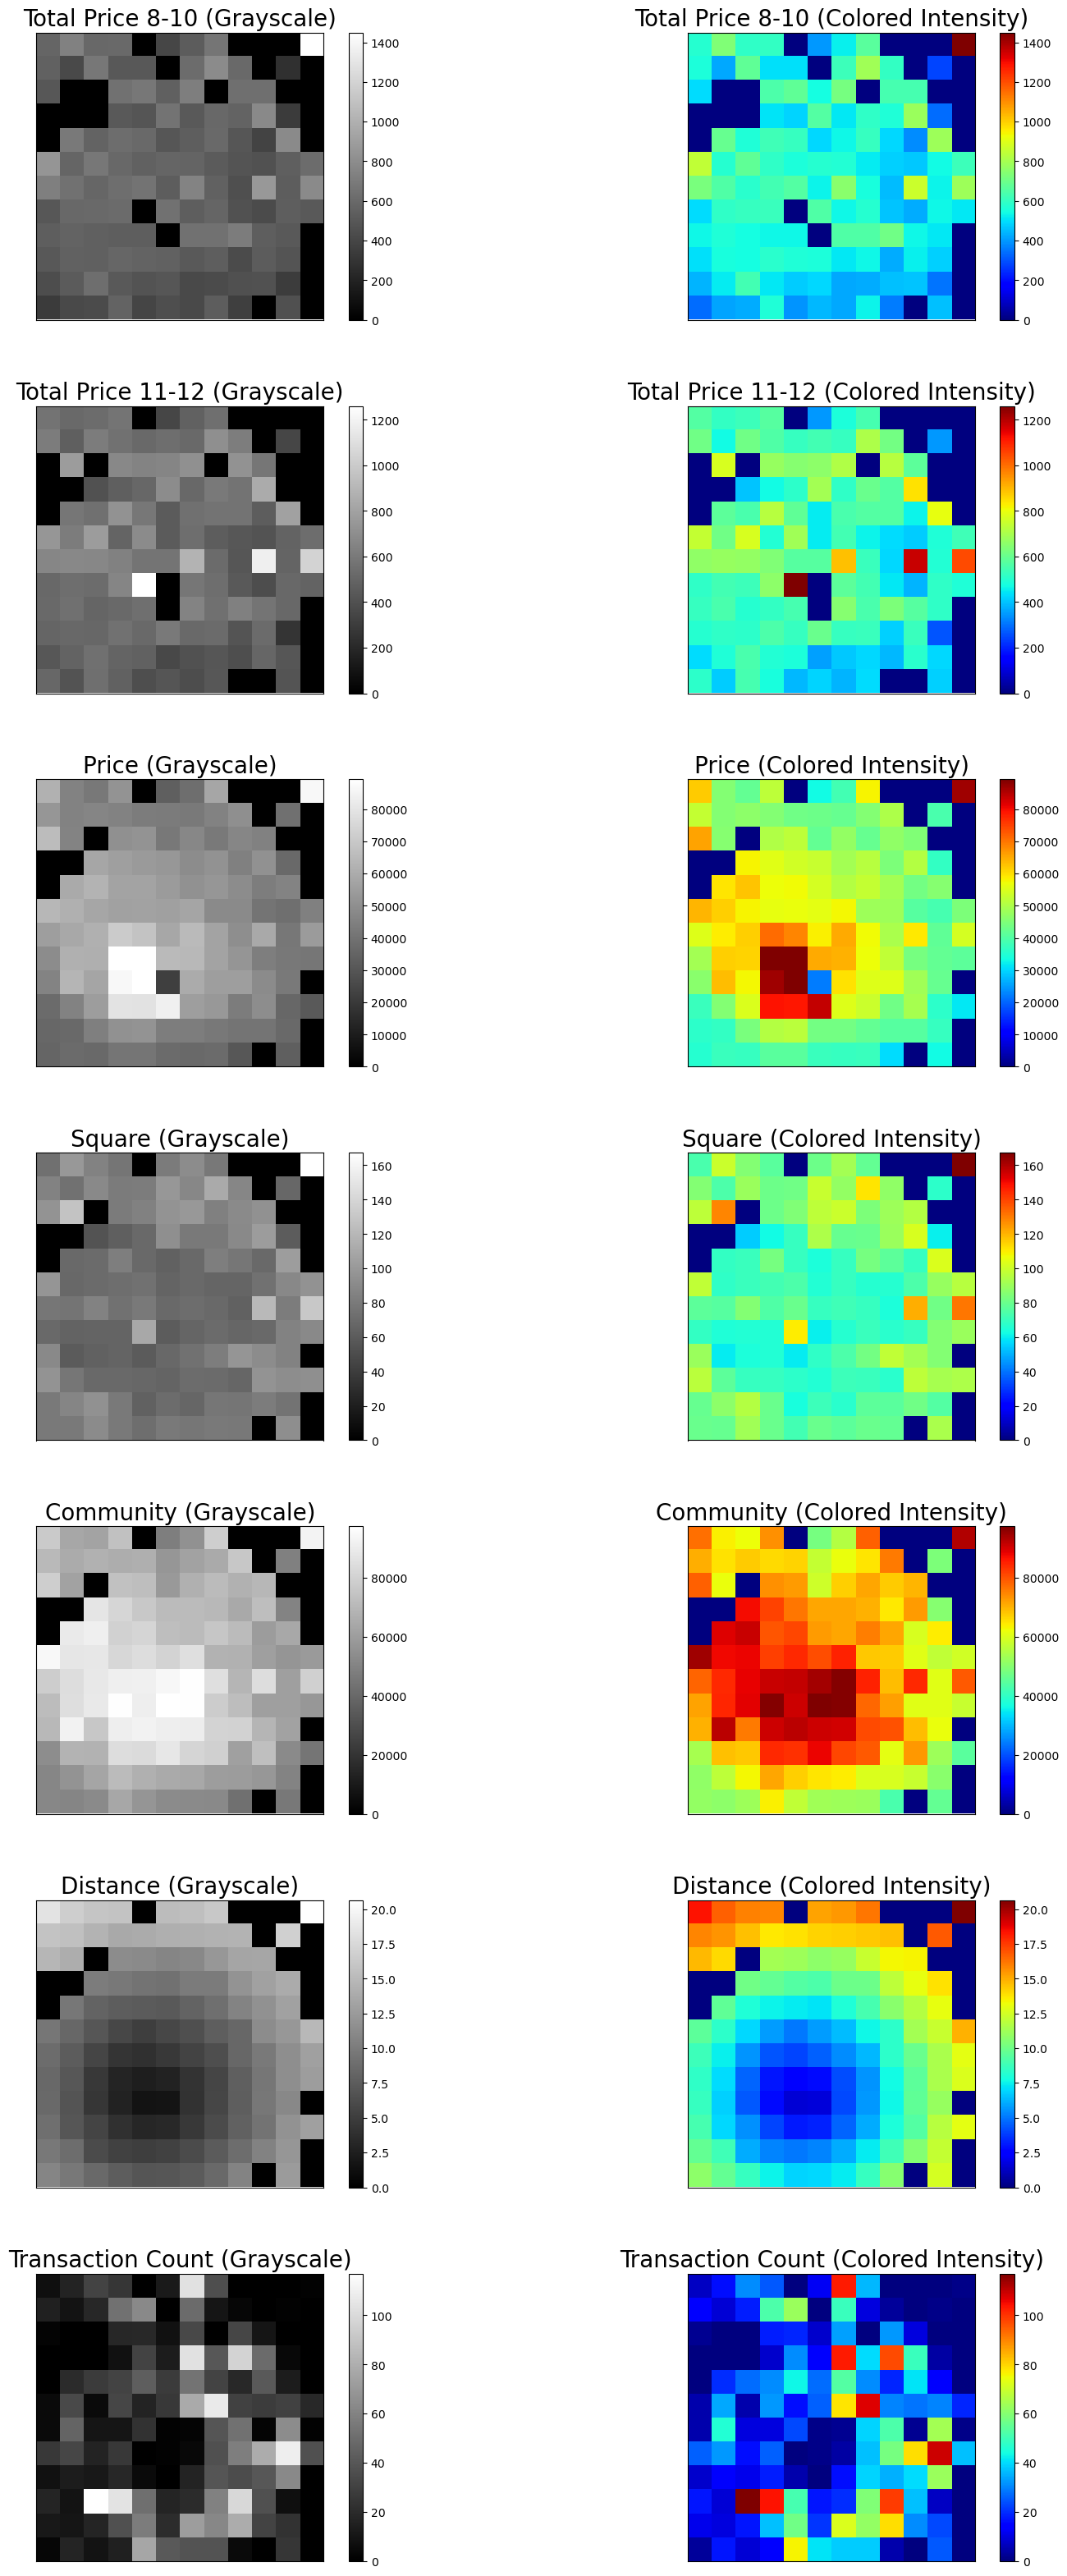

In [15]:
feature_maps = {
    "Total Price 8-10": totalPrice_1,
    "Total Price 11-12": totalPrice_2,
    "Price": price,
    "Square": square,
    "Community": community,
    "Distance": distance,
    "Transaction Count": transaction_cnt_1
}
plot_feature_maps(feature_maps)

In [16]:
def year(start: str, end: str):
    ls = []
    for i in range(end - start + 1):
        cur_month = start + i
        cur_ls = []
        # long term
        cur_ls.append([cur_month - 24, cur_month - 12, cur_month])
        ls.append(cur_ls)
        # short term
        cur_ls.append([cur_month - 12 + j for j in range(12)])
        # ingredients
        cur_ls.append([cur_month - 12, cur_month])
        # future expectation
        cur_ls.append([cur_month - 1, cur_month])
        # traning label
        cur_ls.append([cur_month + 1]) 
    return ls

In [ ]:
# short term price set as 12 months, shape: 12x(grid_num)x(grid_num)
# long term price set as 2 years, shape: 2x(grid_num)x(grid_num)
# ingredients set as 1 year, shape: (6+k)x(grid_num)x(grid_num)
# future expectation set as 2 months, shape: 2x(grid_num)x(grid_num)
# label set as 1 month, shape: 1x(grid_num)x(grid_num)

def generate_npz_JGC_MMN(path: str, t):
    long_term_tensor = []
    short_term_tensor = []
    ingredients_tensor = []
    future_tensor = []
    label_tensor = []
    for cur_t in t:
        # long term
        long_price = []
        long_cnt = []
        for cur_y in range(len(cur_t[0]) - 1):
            l_price, l_cnt = cal_house_price_mat(cur_t[0][cur_y], cur_t[0][cur_y + 1])
            long_price.append(l_price)
            long_cnt.append(l_cnt)
        long_term_tensor.append(np.stack(long_price + long_cnt, axis=0))
        # short term
        short_price = []
        short_cnt = []
        for cur_m in cur_t[1]:
            s_price, s_cnt = cal_house_price_mat(cur_m, cur_m)
            short_price.append(s_price)
            short_cnt.append(s_cnt)
        short_term_tensor.append(np.stack(short_price + short_cnt, axis=0))
        # ingredients
        ingre_arr = []
        for cur_m in range(len(cur_t[2]) - 1):
            cur_y = cur_t[2][cur_m] // 12 - 2012
            for eco in economics:
                ingre_arr.append(np.full((grid_num, grid_num), eco[cur_y]))
            ingre_arr.extend(cal_ingredients_mat(cur_t[2][cur_m], cur_t[2][cur_m + 1]))
        ingredients_tensor.append(np.stack(ingre_arr, axis=0))
        # future expectation
        future_arr = []
        for cur_m in cur_t[3]:
            future_arr.append(cal_house_price_mat(cur_m, cur_m)[0])
        future_tensor.append(np.stack(future_arr, axis=0))
        # label
        year = cur_t[4][0] // 12
        month = cur_t[4][0] % 12
        if month == 0:
            print("label: ", year - 1, 12)
        else:
            print("label: ", year, month)  
        label_tensor.append(np.stack([cal_house_price_mat(cur_t[4][0], cur_t[4][0])[0]], axis=0))
    long_term_tensor = np.stack(long_term_tensor, axis=0)
    short_term_tensor = np.stack(short_term_tensor, axis=0)
    ingredients_tensor = np.stack(ingredients_tensor, axis=0)
    future_tensor = np.stack(future_tensor, axis=0)
    label_tensor = np.stack(label_tensor, axis=0)
    print("--------------------------------------------------")
    print("long term tensor shape: ", long_term_tensor.shape)
    print("short term tensor shape: ", short_term_tensor.shape)
    print("ingredients tensor shape: ", ingredients_tensor.shape)
    print("future tensor shape: ", future_tensor.shape)
    print("label tensor shape: ", label_tensor.shape)
    print("--------------------------------------------------")
    np.save(path + "long_term.npy", long_term_tensor)
    np.save(path + "short_term.npy", short_term_tensor)
    np.save(path + "ingredients.npy", ingredients_tensor)
    np.save(path + "future.npy", future_tensor)
    np.save(path + "label.npy", label_tensor)

Generate data for JGC_MMN

In [18]:
# t1 = year(2014 * 12 + 1, 2017 * 12 + 11)
# generate_npz_JGC_MMN("../../Datasets/Beijing_House_Price_Dataset/JGC_MMN/train/", t1)

In [19]:
# t2 = year(2017 * 12 + 12, 2017 * 12 + 12)
# generate_npz_JGC_MMN("../../Datasets/Beijing_House_Price_Dataset/JGC_MMN/test/", t2)

Generate data for St-ResNet

In [20]:
# short term price set as 12 months, shape: 12x(grid_num)x(grid_num)
# long term price set as 2 years, shape: 2x(grid_num)x(grid_num)
# ingredients set as 1 year, shape: (6+k)x(grid_num)x(grid_num)
# future expectation set as 2 months, shape: 2x(grid_num)x(grid_num)
# label set as 1 month, shape: 1x(grid_num)x(grid_num)

def generate_npz_St_ResNet(path: str, t):
    long_term_tensor = []
    short_term_tensor = []
    ingredients_tensor = []
    externel_tensor = []
    future_tensor = []
    label_tensor = []
    for cur_t in t:
        # long term
        long_price = []
        long_cnt = []
        for cur_y in range(len(cur_t[0]) - 1):
            l_price, l_cnt = cal_house_price_mat(cur_t[1][cur_y], cur_t[1][cur_y + 1])
            long_price.append(l_price)
            long_cnt.append(l_cnt)
        long_term_tensor.append(np.stack(long_price + long_cnt, axis=0))
        # short term
        short_price = []
        short_cnt = []
        for cur_m in cur_t[1]:
            s_price, s_cnt = cal_house_price_mat(cur_m, cur_m)
            short_price.append(s_price)
            short_cnt.append(s_cnt)
        short_term_tensor.append(np.stack(short_price + short_cnt, axis=0))
        # ingredients
        ingre_arr = []
        externel_arr = []
        for cur_m in range(len(cur_t[2]) - 1):
            cur_y = cur_t[2][cur_m] // 12 - 2012
            for eco in economics:
                externel_arr.append(eco[cur_y])
            externel_tensor.append(np.stack(externel_arr, axis=0))
            ingre_arr.extend(cal_ingredients_mat(cur_t[2][cur_m], cur_t[2][cur_m + 1]))
        ingredients_tensor.append(np.stack(ingre_arr, axis=0))
        # future expectation
        future_arr = []
        for cur_m in cur_t[3]:
            future_arr.append(cal_house_price_mat(cur_m, cur_m)[0])
        future_tensor.append(np.stack(future_arr, axis=0))
        # label
        year = cur_t[4][0] // 12
        month = cur_t[4][0] % 12
        if month == 0:
            print("label: ", year - 1, 12)
        else:
            print("label: ", year, month)  
        label_tensor.append(np.stack([cal_house_price_mat(cur_t[4][0], cur_t[4][0])[0]], axis=0))
    long_term_tensor = np.stack(long_term_tensor, axis=0)
    short_term_tensor = np.stack(short_term_tensor, axis=0)
    ingredients_tensor = np.stack(ingredients_tensor, axis=0)
    externel_tensor = np.stack(externel_tensor, axis=0)
    future_tensor = np.stack(future_tensor, axis=0)
    label_tensor = np.stack(label_tensor, axis=0)
    print("--------------------------------------------------")
    print("long term tensor shape: ", long_term_tensor.shape)
    print("short term tensor shape: ", short_term_tensor.shape)
    print("ingredients tensor shape: ", ingredients_tensor.shape)
    print("externel tensor shape: ", externel_tensor.shape)
    print("future tensor shape: ", future_tensor.shape)
    print("label tensor shape: ", label_tensor.shape)
    print("--------------------------------------------------")
    np.save(path + "long_term.npy", long_term_tensor)
    np.save(path + "short_term.npy", short_term_tensor)
    np.save(path + "ingredients.npy", ingredients_tensor)
    np.save(path + "externel.npy", externel_tensor)
    np.save(path + "future.npy", future_tensor)
    np.save(path + "label.npy", label_tensor)

In [21]:
# t1 = year(2014 * 12 + 1, 2016 * 12 + 12)
# generate_npz_St_ResNet("../../Datasets/Beijing_House_Price_Dataset/St-ResNet/train/", t1)

In [22]:
# t2 = year(2017 * 12 + 1, 2017 * 12 + 12)
# generate_npz_St_ResNet("../../Datasets/Beijing_House_Price_Dataset/St-ResNet/test/", t2)